Unique Categories:
['Books & Reference' 'Comics' 'Health & Fitness' 'Social' 'Entertainment'
 'Weather' 'Communication' 'Sports' 'News & Magazines' 'Finance'
 'Shopping' 'Education' 'Travel & Local' 'Business' 'Medical' 'Beauty'
 'Food & Drink' 'Dating' 'Auto & Vehicles' 'Music & Audio' 'House & Home'
 'Maps & Navigation' 'Lifestyle' 'Art & Design' 'Parenting' 'Events'
 'Video Players & Editors' '000 - 1']


/var/folders/h1/j89p_r014731jf1ssd2mcdm00000gn/T/ipykernel_50526/4226372099.py:55: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/h1/j89p_r014731jf1ssd2mcdm00000gn/T/ipykernel_50526/4226372099.py:56: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.savefig("weighted_avg_rating_per_category.png")
/Users/kumarsatyam/python/github/rlproject/.venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


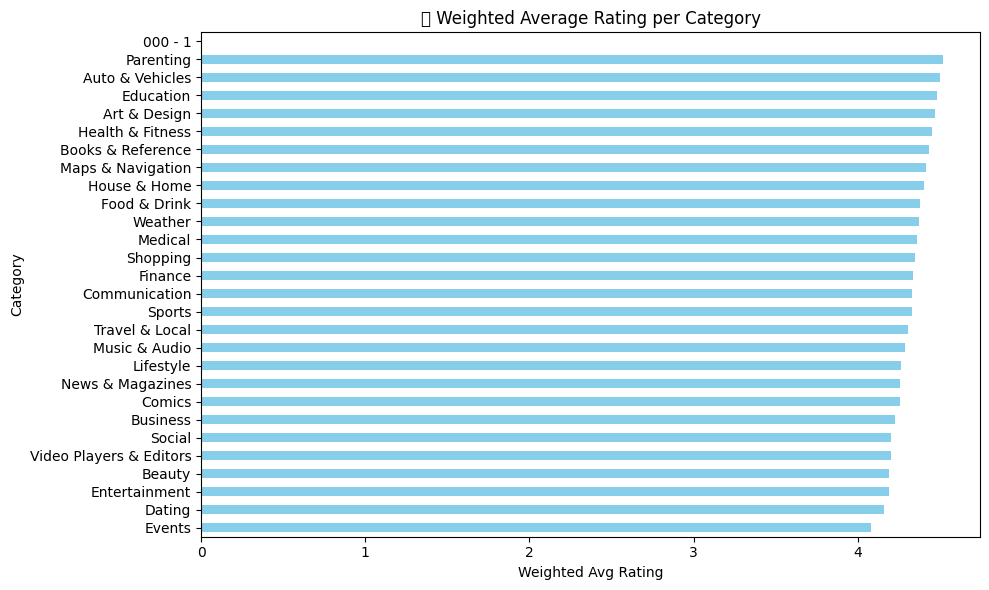

/var/folders/h1/j89p_r014731jf1ssd2mcdm00000gn/T/ipykernel_50526/4226372099.py:64: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/h1/j89p_r014731jf1ssd2mcdm00000gn/T/ipykernel_50526/4226372099.py:65: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.savefig("total_downloads_per_category.png")
/Users/kumarsatyam/python/github/rlproject/.venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


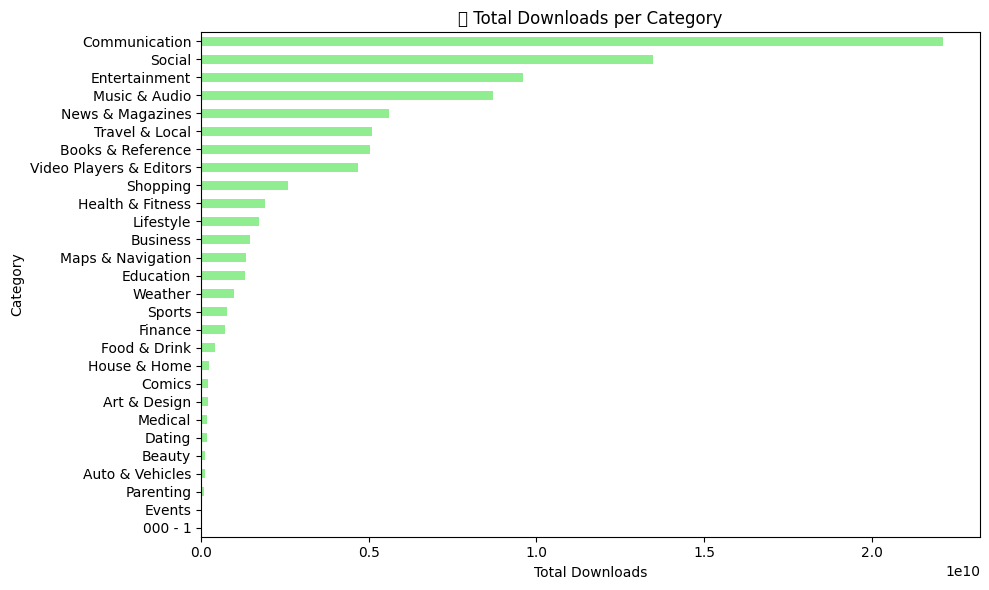

/var/folders/h1/j89p_r014731jf1ssd2mcdm00000gn/T/ipykernel_50526/4226372099.py:73: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/h1/j89p_r014731jf1ssd2mcdm00000gn/T/ipykernel_50526/4226372099.py:74: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.savefig("adjusted_rating_per_category.png")
/Users/kumarsatyam/python/github/rlproject/.venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


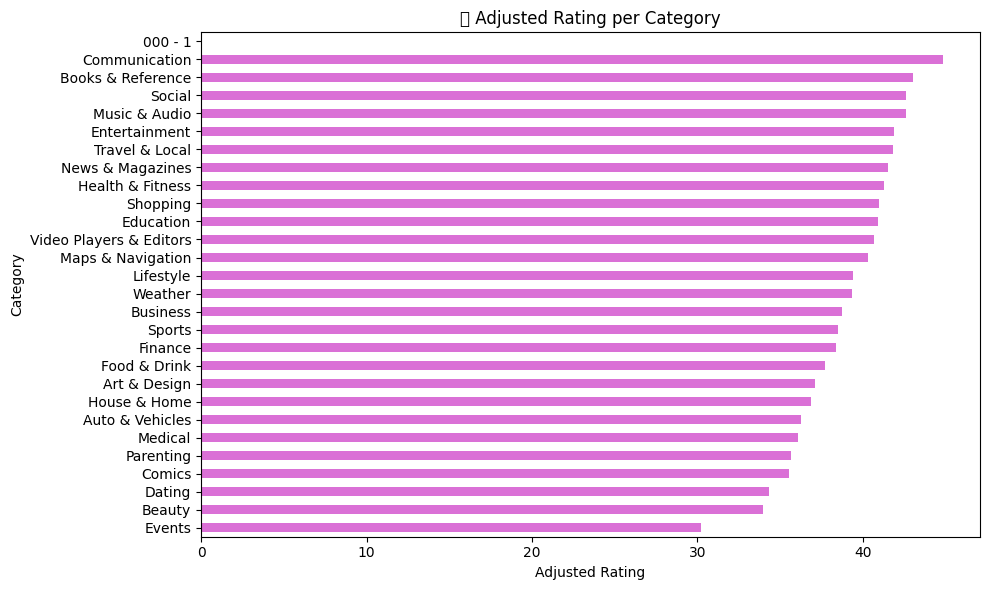

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np

# === LOAD CSV FILE ===
df = pd.read_csv("app_details.csv")

# === CLEAN AND PREPROCESS ===
df.columns = df.columns.str.strip()
df['Category'] = df['Category'].str.strip()
df['Average Rating'] = pd.to_numeric(df['Average Rating'], errors='coerce')
df['Number of Ratings'] = pd.to_numeric(df['Number of Ratings'], errors='coerce')

# === PARSE NUMBER OF DOWNLOADS ===
def parse_downloads(x):
    m = re.findall(r"(\d[\d,]*)", str(x))
    if len(m) == 2:
        return (int(m[0].replace(",", "")) + int(m[1].replace(",", ""))) // 2
    elif len(m) == 1:
        return int(m[0].replace(",", ""))
    return 0

df['Downloads'] = df['Number of Downloads'].apply(parse_downloads)

# === PRINT UNIQUE CATEGORIES ===
unique_categories = df['Category'].unique()
print("Unique Categories:")
print(unique_categories)

# === PLOT 1: WEIGHTED AVERAGE RATING PER CATEGORY ===
df['Weighted Rating'] = df['Average Rating'] * df['Number of Ratings']
category_stats = df.groupby('Category').agg(
    total_weighted_rating=('Weighted Rating', 'sum'),
    total_ratings=('Number of Ratings', 'sum')
)
category_stats['Avg Rating (Weighted)'] = category_stats['total_weighted_rating'] / category_stats['total_ratings']
category_stats = category_stats.sort_values('Avg Rating (Weighted)', ascending=True)

# === PLOT 2: TOTAL DOWNLOADS PER CATEGORY ===
downloads_by_category = df.groupby('Category')['Downloads'].sum().sort_values(ascending=True)

# === COMBINED METRIC: ADJUSTED RATING ===
combined_stats = pd.concat([category_stats, downloads_by_category.rename("Total Downloads")], axis=1)
combined_stats['Adjusted Rating'] = combined_stats['Avg Rating (Weighted)'] * np.log10(combined_stats['Total Downloads'] + 1)

# === PLOTTING ===

plt.figure(figsize=(10, 6))
category_stats['Avg Rating (Weighted)'].plot(kind='barh', color='skyblue')
plt.title("📊 Weighted Average Rating per Category")
plt.xlabel("Weighted Avg Rating")
plt.ylabel("Category")
plt.tight_layout()
plt.savefig("weighted_avg_rating_per_category.png")
plt.show()

plt.figure(figsize=(10, 6))
downloads_by_category.plot(kind='barh', color='lightgreen')
plt.title("📈 Total Downloads per Category")
plt.xlabel("Total Downloads")
plt.ylabel("Category")
plt.tight_layout()
plt.savefig("total_downloads_per_category.png")
plt.show()

plt.figure(figsize=(10, 6))
combined_stats['Adjusted Rating'].sort_values(ascending=True).plot(kind='barh', color='orchid')
plt.title("📊 Adjusted Rating per Category")
plt.xlabel("Adjusted Rating")
plt.ylabel("Category")
plt.tight_layout()
plt.savefig("adjusted_rating_per_category.png")
plt.show()

used parallel procecessing so directly ran it terminal

In [ ]:
# FINAL: Full Caching + 200k Training + Evaluation (Optimized for GPU/MPS)

import os, json, re, random, time, gc
import numpy as np
import pandas as pd
from PIL import Image
from collections import deque, defaultdict
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, models
from multiprocessing import Pool, cpu_count

# === SETUP ===
COMBINED_DIR = "combined"
SEM_ANN_DIR = "semantic_annotations"
CACHE_DIR = "cache_features"
APP_DETAILS_PATH = "app_details.csv"
UI_DETAILS_PATH = "ui_details.csv"
COMPONENT_LEGEND_PATH = "component_legend.json"
TEXTBUTTON_LEGEND_PATH = "textButton_legend.json"
ICON_LEGEND_PATH = "icon_legend.json"

os.makedirs(CACHE_DIR, exist_ok=True)
device = torch.device("cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu"))
print("Using device:", device)

# === DATA ===
apps = pd.read_csv(APP_DETAILS_PATH)
ui_map = pd.read_csv(UI_DETAILS_PATH)

def parse_downloads(x):
    m = re.findall(r"(\d[\d,]*)", str(x))
    return (int(m[0].replace(",", "")) + int(m[1].replace(",", ""))) // 2 if len(m) == 2 else int(m[0].replace(",", "")) if m else 0

apps['rating_norm'] = apps['Average Rating'] / 5.0
apps['downloads'] = apps['Number of Downloads'].apply(parse_downloads)
apps['downloads_log'] = np.log1p(apps['downloads'])
apps['dl_norm'] = (apps['downloads_log'] - apps['downloads_log'].min()) / (apps['downloads_log'].max() - apps['downloads_log'].min())
apps['app_score'] = 0.7 * apps['rating_norm'] + 0.3 * apps['dl_norm']
app_scores = dict(zip(apps['App Package Name'], apps['app_score']))

# === LEGENDS + TRANSFORMS ===
legend_paths = [COMPONENT_LEGEND_PATH, TEXTBUTTON_LEGEND_PATH, ICON_LEGEND_PATH]
all_labels, rgb_label_map = [], {}
for path in legend_paths:
    with open(path) as f:
        legend = json.load(f)
    all_labels += legend.keys()
    rgb_label_map.update({tuple(v["rgb"]): k for k, v in legend.items()})

img_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# === CACHING ===
def extract_layout(json_path):
    with open(json_path) as f:
        data = json.load(f)
    total, clickable, visible = 0, 0, 0
    def walk(n):
        nonlocal total, clickable, visible
        total += 1
        clickable += int(n.get("clickable", False))
        visible += int(n.get("visibility", "") == "visible")
        for c in n.get("children", []):
            walk(c)
    walk(data["activity"]["root"])
    return np.array([total, clickable, visible], dtype=np.float32)

def extract_semantic(mask_path):
    mask = Image.open(mask_path).convert("RGB")
    mask_np = np.array(mask)
    counts = defaultdict(int)
    for row in mask_np:
        for pixel in row:
            label = rgb_label_map.get(tuple(pixel))
            if label:
                counts[label] += 1
    vec = np.array([counts[k] for k in all_labels], dtype=np.float32)
    return vec / (vec.sum() + 1e-6)

def cache_ui_features(row):
    try:
        ui_number = int(row["UI Number"])
        out_path = os.path.join(CACHE_DIR, f"{ui_number}.npz")
        if os.path.exists(out_path):
            return "skipped"
        img_path = os.path.join(COMBINED_DIR, f"{ui_number}.jpg")
        json_path = os.path.join(COMBINED_DIR, f"{ui_number}.json")
        mask_path = os.path.join(SEM_ANN_DIR, f"{ui_number}.png")
        if not all(map(os.path.exists, [img_path, json_path, mask_path])):
            return "missing"
        img_tensor = img_transform(Image.open(img_path).convert("RGB")).numpy()
        layout_feat = extract_layout(json_path)
        semantic_feat = extract_semantic(mask_path)
        np.savez_compressed(out_path, img=img_tensor, layout=layout_feat, semantic=semantic_feat)
        return "cached"
    except Exception as e:
        return f"error: {e}"

def parallel_cache_features():
    print(f"🔄 Caching features using {cpu_count()} cores...")
    with Pool(cpu_count()) as pool:
        results = list(tqdm(pool.imap(cache_ui_features, [row for _, row in ui_map.iterrows()]), total=len(ui_map)))
    print("✅ Caching complete.")
    return results

# === ENVIRONMENT ===
class UIEnv:
    def __init__(self):
        self.df = ui_map
        self.semantic_dim = len(all_labels)

    def reset(self):
        row = self.df.sample(1).iloc[0]
        self.ui_number = row["UI Number"]
        self.pkg = row["App Package Name"]
        npz = np.load(os.path.join(CACHE_DIR, f"{self.ui_number}.npz"))
        self.img = torch.tensor(npz["img"], dtype=torch.float32).unsqueeze(0)
        layout, semantic = npz["layout"], npz["semantic"]
        meta = np.concatenate([layout, semantic])
        self.meta = torch.tensor(meta, dtype=torch.float32).unsqueeze(0)
        self.reward = app_scores.get(self.pkg, 0.0)
        return self.img, self.meta

    def step(self, a):
        return (None, None), self.reward, True, {}

# === MODEL ===
class DuelDQN(nn.Module):
    def __init__(self, n_actions, meta_dim):
        super().__init__()
        self.cnn = models.resnet34(weights="DEFAULT")  #ResNet34
        self.cnn.fc = nn.Linear(self.cnn.fc.in_features, 128)
        self.meta = nn.Sequential(nn.Linear(meta_dim, 64), nn.ReLU())
        self.adv = nn.Sequential(nn.Linear(192, 128), nn.ReLU(), nn.Linear(128, n_actions))
        self.val = nn.Sequential(nn.Linear(192, 128), nn.ReLU(), nn.Linear(128, 1))

    def forward(self, img, meta):
        f_img = self.cnn(img.to(device))
        f_meta = self.meta(meta.to(device))
        x = torch.cat([f_img, f_meta], dim=1)
        return self.val(x) + self.adv(x) - self.adv(x).mean(dim=1, keepdim=True)

# === TRAINING ===
from tqdm import tqdm

# === TRAINING (Now 1 lakh episodes with tqdm) ===
def train_dqn_light(episodes=100_000, batch_size=32):
    env = UIEnv()
    meta_dim = 3 + env.semantic_dim
    policy = DuelDQN(n_actions=1, meta_dim=meta_dim).to(device)
    target = DuelDQN(n_actions=1, meta_dim=meta_dim).to(device)
    target.load_state_dict(policy.state_dict())
    opt = optim.Adam(policy.parameters(), lr=1e-4)
    buf = deque(maxlen=10000)
    eps, eps_min, decay = 1.0, 0.1, 1e-6
    rewards = []
    seen_uis = set()

    pbar = tqdm(total=episodes, desc="Training Progress")

    for ep in range(episodes):
        try:
            img, meta = env.reset()
            img, meta = img.to(device), meta.to(device)
            r = env.reward
            buf.append((img, meta, r))
            seen_uis.add(env.ui_number)

            if len(buf) >= batch_size:
                batch = random.sample(buf, batch_size)
                imgs = torch.cat([b[0] for b in batch])
                metas = torch.cat([b[1] for b in batch])
                rews = torch.tensor([b[2] for b in batch], device=device)
                qvals = policy(imgs, metas).squeeze()
                loss = F.mse_loss(qvals, rews)
                opt.zero_grad()
                loss.backward()
                opt.step()
                del imgs, metas, rews, qvals
                gc.collect()

            eps = max(eps_min, eps - decay)
            rewards.append(r)
            pbar.update(1)

            if ep % 1000 == 0:
                pbar.set_postfix({"Reward": f"{r:.3f}", "eps": f"{eps:.4f}", "Seen UIs": len(seen_uis)})
                target.load_state_dict(policy.state_dict())

            if ep % 50000 == 0 and ep > 0:
                torch.save(policy.state_dict(), f"dqn_checkpoint_ep{ep}.pth")
                print(f"✅ Saved checkpoint at {ep} episodes.")

        except Exception as e:
            print(f"[⚠️ Ep {ep}] {e}")
            continue

    pbar.close()

    plt.plot(rewards)
    plt.title("Reward per Episode (1L Training)")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.grid(True)
    plt.savefig("reward_plot_1L.png")
    plt.show()
    torch.save(policy.state_dict(), "dqn_model_final_1L.pth")
    return policy

# === EVALUATION ===
def evaluate_lightweight(model_path="dqn_model_final.pth", num_samples=100):
    model = DuelDQN(n_actions=1, meta_dim=3 + len(all_labels)).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    scores = []

    for _, row in ui_map.sample(n=num_samples).iterrows():
        try:
            ui_number = row["UI Number"]
            pkg = row["App Package Name"]
            npz_path = os.path.join(CACHE_DIR, f"{ui_number}.npz")
            if not os.path.exists(npz_path):
                continue
            npz = np.load(npz_path)
            img = torch.tensor(npz["img"], dtype=torch.float32).unsqueeze(0).to(device)
            layout, semantic = npz["layout"], npz["semantic"]
            meta = torch.tensor(np.concatenate([layout, semantic]), dtype=torch.float32).unsqueeze(0).to(device)

            with torch.no_grad():
                qval = model(img, meta).item()
            gt = app_scores.get(pkg, 0.0)
            scores.append((pkg, qval, gt))
        except Exception as e:
            print(f"[Eval UI {row['UI Number']}] {e}")
            continue

    df = pd.DataFrame(scores, columns=["Package", "Predicted", "Ground Truth"])
    corr = df[["Predicted", "Ground Truth"]].corr().iloc[0, 1]
    print(f"🔍 Lightweight Eval Corr: {corr:.4f}")

    # --- Plotting ---
    plt.scatter(df["Ground Truth"], df["Predicted"], alpha=0.6)
    plt.xlabel("Ground Truth App Score")
    plt.ylabel("Predicted Score")
    plt.title("Ground Truth vs Predicted Score (Evaluation)")
    plt.grid(True)
    plt.savefig("evaluation_scatter.png")
    plt.show()

    return df

# === MAIN ===
if __name__ == "__main__":
    parallel_cache_features()
    model = train_dqn_light()
    evaluate_lightweight("dqn_model_final_1L.pth")


![Screenshot](reward_plot_1L.png)

Using device: mps
🔍 Lightweight Eval Corr: 0.8063


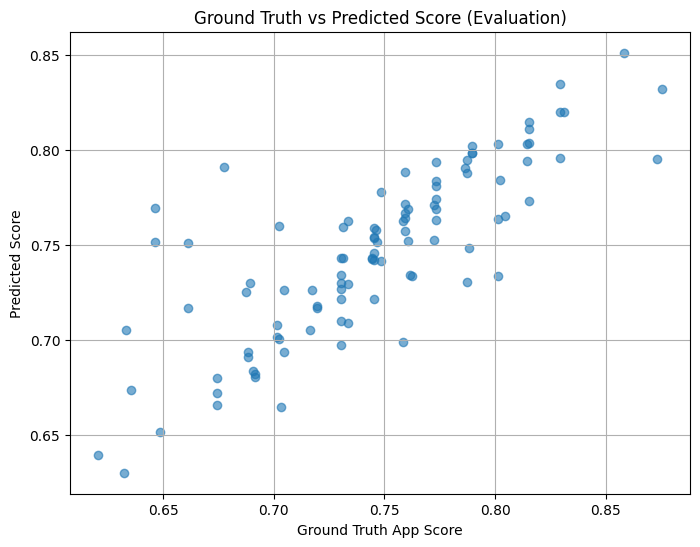

,Package,Predicted,Ground Truth
0,com.stockmarket.pennystocks,0.729999,0.730536
1,com.kdvr.localtv,0.639368,0.620728
2,com.GoFundMe.GoFundMe,0.768633,0.773402
3,com.playon.playonapp,0.750815,0.661402
4,com.appriss.mobilepatrol,0.759077,0.745402
...,...,...,...
95,com.caught.offsidetwo,0.671752,0.674536
96,com.thetransitapp.droid,0.766616,0.759402
97,com.nclexpn.hlt,0.790463,0.786536
98,com.lockermaster.scene.frame.lovephoto,0.733560,0.801402


In [1]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
from torchvision import transforms, models
from collections import defaultdict

# === Paths ===
COMBINED_DIR = "combined"
SEM_ANN_DIR = "semantic_annotations"
CACHE_DIR = "cache_features"
APP_DETAILS_PATH = "app_details.csv"
UI_DETAILS_PATH = "ui_details.csv"
COMPONENT_LEGEND_PATH = "component_legend.json"
TEXTBUTTON_LEGEND_PATH = "textButton_legend.json"
ICON_LEGEND_PATH = "icon_legend.json"

# === Device ===
device = torch.device("cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu"))
print(f"Using device: {device}")

# === Load metadata ===
apps = pd.read_csv(APP_DETAILS_PATH)
ui_map = pd.read_csv(UI_DETAILS_PATH)

def parse_downloads(x):
    import re
    m = re.findall(r"(\d[\d,]*)", str(x))
    return (int(m[0].replace(",", "")) + int(m[1].replace(",", ""))) // 2 if len(m) == 2 else (int(m[0].replace(",", "")) if m else 0)

apps['rating_norm'] = apps['Average Rating'] / 5.0
apps['downloads'] = apps['Number of Downloads'].apply(parse_downloads)
apps['downloads_log'] = np.log1p(apps['downloads'])
apps['dl_norm'] = (apps['downloads_log'] - apps['downloads_log'].min()) / (apps['downloads_log'].max() - apps['downloads_log'].min())
apps['app_score'] = 0.7 * apps['rating_norm'] + 0.3 * apps['dl_norm']
app_scores = dict(zip(apps['App Package Name'], apps['app_score']))

# === Legends ===
legend_paths = [COMPONENT_LEGEND_PATH, TEXTBUTTON_LEGEND_PATH, ICON_LEGEND_PATH]
all_labels = []
for path in legend_paths:
    with open(path) as f:
        legend = json.load(f)
    all_labels += legend.keys()

# === Model ===
class DuelDQN(nn.Module):
    def __init__(self, n_actions, meta_dim):
        super().__init__()
        self.cnn = models.resnet34(weights="DEFAULT")
        self.cnn.fc = nn.Linear(self.cnn.fc.in_features, 128)
        self.meta = nn.Sequential(nn.Linear(meta_dim, 64), nn.ReLU())
        self.adv = nn.Sequential(nn.Linear(192, 128), nn.ReLU(), nn.Linear(128, n_actions))
        self.val = nn.Sequential(nn.Linear(192, 128), nn.ReLU(), nn.Linear(128, 1))

    def forward(self, img, meta):
        f_img = self.cnn(img.to(device))
        f_meta = self.meta(meta.to(device))
        x = torch.cat([f_img, f_meta], dim=1)
        return self.val(x) + self.adv(x) - self.adv(x).mean(dim=1, keepdim=True)

# === Evaluation Function ===
def evaluate_lightweight(model_path="dqn_model_final_1L.pth", num_samples=100):
    model = DuelDQN(n_actions=1, meta_dim=3 + len(all_labels)).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    scores = []

    for _, row in ui_map.sample(n=num_samples).iterrows():
        try:
            ui_number = row["UI Number"]
            pkg = row["App Package Name"]
            npz_path = os.path.join(CACHE_DIR, f"{ui_number}.npz")
            if not os.path.exists(npz_path):
                continue
            npz = np.load(npz_path)
            img = torch.tensor(npz["img"], dtype=torch.float32).unsqueeze(0).to(device)
            layout, semantic = npz["layout"], npz["semantic"]
            meta = torch.tensor(np.concatenate([layout, semantic]), dtype=torch.float32).unsqueeze(0).to(device)

            with torch.no_grad():
                qval = model(img, meta).item()
            gt = app_scores.get(pkg, 0.0)
            scores.append((pkg, qval, gt))
        except Exception as e:
            print(f"[Eval UI {row['UI Number']}] {e}")
            continue

    df = pd.DataFrame(scores, columns=["Package", "Predicted", "Ground Truth"])
    corr = df[["Predicted", "Ground Truth"]].corr().iloc[0, 1]
    print(f"🔍 Lightweight Eval Corr: {corr:.4f}")

    # --- Plotting ---
    plt.figure(figsize=(8,6))
    plt.scatter(df["Ground Truth"], df["Predicted"], alpha=0.6)
    plt.xlabel("Ground Truth App Score")
    plt.ylabel("Predicted Score")
    plt.title("Ground Truth vs Predicted Score (Evaluation)")
    plt.grid(True)
    plt.show()

    return df

# === RUN EVALUATION ===
evaluate_lightweight("dqn_model_final_1L.pth")

 com.madieo.imovie            
 app rating- 2.1
 
 tested with lower rate rating app

In [16]:
import os, json, re, random, time, gc
import numpy as np
import pandas as pd
from PIL import Image
from collections import deque, defaultdict
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, models
from multiprocessing import Pool, cpu_count
device = torch.device("cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu"))

CACHE_DIR = "cache_features"
COMBINED_DIR = "combined"
SEM_ANN_DIR = "semantic_annotations"
CACHE_DIR = "cache_features"
APP_DETAILS_PATH = "app_details.csv"
UI_DETAILS_PATH = "ui_details.csv"
COMPONENT_LEGEND_PATH = "component_legend.json"
TEXTBUTTON_LEGEND_PATH = "textButton_legend.json"
ICON_LEGEND_PATH = "icon_legend.json"
legend_paths = [COMPONENT_LEGEND_PATH, TEXTBUTTON_LEGEND_PATH, ICON_LEGEND_PATH]

all_labels = []
for path in legend_paths:
    with open(path) as f:
        legend = json.load(f)
    all_labels += legend.keys()
class DuelDQN(nn.Module):
    def __init__(self, n_actions, meta_dim):
        super().__init__()
        self.cnn = models.resnet18(weights="DEFAULT")
        self.cnn.fc = nn.Linear(self.cnn.fc.in_features, 128)
        self.meta = nn.Sequential(nn.Linear(meta_dim, 64), nn.ReLU())
        self.adv = nn.Sequential(nn.Linear(192, 128), nn.ReLU(), nn.Linear(128, n_actions))
        self.val = nn.Sequential(nn.Linear(192, 128), nn.ReLU(), nn.Linear(128, 1))

    def forward(self, img, meta):
        f_img = self.cnn(img.to(device))
        f_meta = self.meta(meta.to(device))
        x = torch.cat([f_img, f_meta], dim=1)
        return self.val(x) + self.adv(x) - self.adv(x).mean(dim=1, keepdim=True)
# Predict score for a specific UI
def predict_ui_score(ui_number, model_path="dqn_model_optimized.pth"):
    model = DuelDQN(n_actions=1, meta_dim=3 + len(all_labels)).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    npz_path = os.path.join(CACHE_DIR, f"{ui_number}.npz")
    if not os.path.exists(npz_path):
        print(f"❌ UI {ui_number} not found in cache.")
        return

    npz = np.load(npz_path)
    img = torch.tensor(npz["img"], dtype=torch.float32).unsqueeze(0).to(device)
    layout = npz["layout"]
    semantic = npz["semantic"]
    meta = torch.tensor(np.concatenate([layout, semantic]), dtype=torch.float32).unsqueeze(0).to(device)

    with torch.no_grad():
        pred_score = model(img, meta).item()
    print(f"⭐ Predicted UI {ui_number} Score: {pred_score:.4f}")

# Example:
predict_ui_score(18074)


⭐ Predicted UI 18074 Score: 0.7347


In [6]:
import pandas as pd

# === LOAD CSV FILE ===
df = pd.read_csv("app_details.csv")

# === CLEAN AND PREPROCESS ===
df['Average Rating'] = pd.to_numeric(df['Average Rating'], errors='coerce')

# === GET 5 APPS WITH LOWEST RATING AND SELECT COLUMNS ===
lowest_apps = df.sort_values('Average Rating').head(5)[["App Package Name", "Average Rating"]]
print(lowest_apps)

                                   App Package Name  Average Rating
5487                             co.inbox.messenger            -1.0
8404                         net.ayudaporfavor.Love             0.0
1946  com.freeappshouse.oldage.futuremirror.lookold             1.7
8953                            com.app.guidelenses             2.1
9355                              com.madieo.imovie             2.1


com.syncme.syncmeapp
with 4.5 rating


In [15]:
import os, json, re, random, time, gc
import numpy as np
import pandas as pd
from PIL import Image
from collections import deque, defaultdict
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, models
from multiprocessing import Pool, cpu_count
device = torch.device("cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu"))

CACHE_DIR = "cache_features"
COMBINED_DIR = "combined"
SEM_ANN_DIR = "semantic_annotations"
CACHE_DIR = "cache_features"
APP_DETAILS_PATH = "app_details.csv"
UI_DETAILS_PATH = "ui_details.csv"
COMPONENT_LEGEND_PATH = "component_legend.json"
TEXTBUTTON_LEGEND_PATH = "textButton_legend.json"
ICON_LEGEND_PATH = "icon_legend.json"
legend_paths = [COMPONENT_LEGEND_PATH, TEXTBUTTON_LEGEND_PATH, ICON_LEGEND_PATH]

all_labels = []
for path in legend_paths:
    with open(path) as f:
        legend = json.load(f)
    all_labels += legend.keys()
class DuelDQN(nn.Module):
    def __init__(self, n_actions, meta_dim):
        super().__init__()
        self.cnn = models.resnet18(weights="DEFAULT")
        self.cnn.fc = nn.Linear(self.cnn.fc.in_features, 128)
        self.meta = nn.Sequential(nn.Linear(meta_dim, 64), nn.ReLU())
        self.adv = nn.Sequential(nn.Linear(192, 128), nn.ReLU(), nn.Linear(128, n_actions))
        self.val = nn.Sequential(nn.Linear(192, 128), nn.ReLU(), nn.Linear(128, 1))

    def forward(self, img, meta):
        f_img = self.cnn(img.to(device))
        f_meta = self.meta(meta.to(device))
        x = torch.cat([f_img, f_meta], dim=1)
        return self.val(x) + self.adv(x) - self.adv(x).mean(dim=1, keepdim=True)
# Predict score for a specific UI
def predict_ui_score(ui_number, model_path="dqn_model_optimized.pth"):
    model = DuelDQN(n_actions=1, meta_dim=3 + len(all_labels)).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    npz_path = os.path.join(CACHE_DIR, f"{ui_number}.npz")
    if not os.path.exists(npz_path):
        print(f"❌ UI {ui_number} not found in cache.")
        return

    npz = np.load(npz_path)
    img = torch.tensor(npz["img"], dtype=torch.float32).unsqueeze(0).to(device)
    layout = npz["layout"]
    semantic = npz["semantic"]
    meta = torch.tensor(np.concatenate([layout, semantic]), dtype=torch.float32).unsqueeze(0).to(device)

    with torch.no_grad():
        pred_score = model(img, meta).item()
    print(f"⭐ Predicted UI {ui_number} Score: {pred_score:.4f}")

# Example:
predict_ui_score(10594)

⭐ Predicted UI 10594 Score: 0.7915
